# Supervised Learning (Regression)

In supervised learning, the task is to infer hidden structure from
labeled data, comprised of training examples $\{(x_n, y_n)\}$.
Regression typically means the output $y$ takes continuous values.

This example is from the documentation for Edward.  A webpage version is available at
http://edwardlib.org/tutorials/supervised-regression.

In [2]:
%matplotlib inline

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

## Data

Simulate training and test sets of $40$ data points. They comprise of
pairs of inputs $\mathbf{x}_n\in\mathbb{R}^{10}$ and outputs
$y_n\in\mathbb{R}$. They have a linear dependence with normally
distributed noise.

In [3]:
def build_toy_dataset(N, w):
  D = len(w)
  x = np.random.normal(0.0, 2.0, size=(N, D))
  y = np.dot(x, w) + np.random.normal(0.0, 0.01, size=N)
  return x, y


ed.set_seed(42)

N = 40  # number of data points
D = 10  # number of features

w_true = np.random.randn(D) * 0.5
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

## Model

Posit the model as Bayesian linear regression (Murphy, 2012).
It assumes a linear relationship between the inputs
$\mathbf{x}\in\mathbb{R}^D$ and the outputs $y\in\mathbb{R}$.

For a set of $N$ data points $(\mathbf{X},\mathbf{y})=\{(\mathbf{x}_n, y_n)\}$,
the model posits the following distributions:

\begin{align*}
  p(\mathbf{w})
  &=
  \text{Normal}(\mathbf{w} \mid \mathbf{0}, \sigma_w^2\mathbf{I}),
  \\[1.5ex]
  p(b)
  &=
  \text{Normal}(b \mid 0, \sigma_b^2),
  \\
  p(\mathbf{y} \mid \mathbf{w}, b, \mathbf{X})
  &=
  \prod_{n=1}^N
  \text{Normal}(y_n \mid \mathbf{x}_n^\top\mathbf{w} + b, \sigma_y^2).
\end{align*}

The latent variables are the linear model's weights $\mathbf{w}$ and
intercept $b$, also known as the bias.
Assume $\sigma_w^2,\sigma_b^2$ are known prior variances and $\sigma_y^2$ is a
known likelihood variance. The mean of the likelihood is given by a
linear transformation of the inputs $\mathbf{x}_n$.

Let's build the model in Edward, fixing $\sigma_w,\sigma_b,\sigma_y=1$.

In [4]:
X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))

Here, we define a placeholder `X`. During inference, we pass in
the value for this placeholder according to data.

## Inference

We now turn to inferring the posterior using variational inference.
Define the variational model to be a fully factorized normal across
the weights.

In [5]:
qw = Normal(loc=tf.get_variable("qw/loc", [D]),
            scale=tf.nn.softplus(tf.get_variable("qw/scale", [D])))
qb = Normal(loc=tf.get_variable("qb/loc", [1]),
            scale=tf.nn.softplus(tf.get_variable("qb/scale", [1])))

Run variational inference with the Kullback-Leibler divergence, using 
$250$ iterations and $5$ latent variable samples in the algorithm.

In [6]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

/Users/furnstah/anaconda3/envs/talent-env-ml2/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 64.053


In this case `KLqp` defaults to minimizing the
$\text{KL}(q\|p)$ divergence measure using the reparameterization
gradient.
For more details on inference, see the [$\text{KL}(q\|p)$ tutorial](http://edwardlib.org/tutorials/klqp).

## Criticism

A standard evaluation for regression is to compare prediction accuracy on
held-out "testing" data. We do this by first forming the posterior predictive
distribution.

In [7]:
y_post = ed.copy(y, {w: qw, b: qb})
# This is equivalent to
# y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(N))

With this we can evaluate various quantities using predictions from
the model (posterior predictive).

In [8]:
print("Mean squared error on test data:")
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:")
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.017143926
Mean absolute error on test data:
0.12141974


The trained model makes predictions with low error
(relative to the magnitude of the output).

We can also visualize the fit by comparing data generated with the
prior to data generated with the posterior (on the first feature
dimension).

In [9]:
def visualise(X_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  b_samples = b.sample(n_samples).eval()
  plt.scatter(X_data[:, 0], y_data)
  plt.ylim([-10, 10])
  inputs = np.linspace(-8, 8, num=400)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

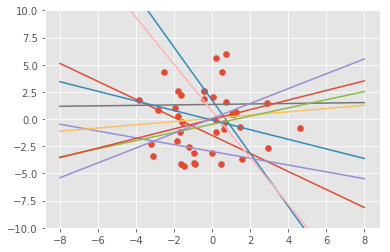

In [10]:
# Visualize samples from the prior.
visualise(X_train, y_train, w, b, n_samples=10)

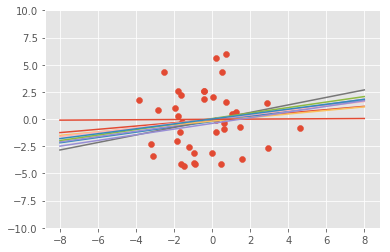

In [11]:
# Visualize samples from the posterior.
visualise(X_train, y_train, qw, qb, n_samples=10)

The model has learned a linear relationship between the
first dimension of $\mathbf{x}\in\mathbb{R}^D$ and the outputs
$y\in\mathbb{R}$.